In [1]:
import sys
sys.path.append('/home/jovyan/intake-aodn')
import intake_aodn
import intake
from  intake_aodn.easicache import set_easi
intake_aodn.cat = set_easi()

/home/jovyan/intake-aodn/intake_aodn/catalogs/aodn_refs.zip aodn_refs.zip s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/aodn_refs.zip
/home/jovyan/intake-aodn/intake_aodn/catalogs/main.yaml main.yaml s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/main.yaml
/home/jovyan/intake-aodn/intake_aodn/catalogs/aodn.yaml aodn.yaml s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/aodn.yaml
/home/jovyan/intake-aodn/intake_aodn/catalogs/nci.yaml nci.yaml s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/nci.yaml


In [2]:
# from intake_aodn.utils import get_distributed_cluster
# client = get_distributed_cluster(worker_memory=4.0)
# client

from intake_aodn.utils import get_local_cluster
client = get_local_cluster(n_workers=16,threads_per_worker=16)
client

<Client: 'tcp://127.0.0.1:8786' processes=16 threads=256, memory=24.00 GiB>

In [3]:
import fsspec
from fsspec.core import url_to_fs
fs = fsspec.filesystem('s3',use_listings_cache=False,anon=True,)

ref_files = fs.glob('s3::imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/*SBE19plus*.nc')
ref_files[0:5]

['imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20130130T000612Z_NRSMAI_FV01_Profile-SBE19plus_C-20160524T001746Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170602T002825Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T024607Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170627T002425Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T025016Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170801T004358Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T021501Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSMAI/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170922T002538Z_NRSMAI_FV01_Profile-SBE19plus_C-20180307T021635Z.nc']

In [82]:
import s3fs
import xarray as xr
from dask import bag as db

def open_cdt(url):
    s3 = s3fs.S3FileSystem(anon=True,default_fill_cache=False,default_cache_type=None)
    with s3.open(url,) as f:
        data=xr.open_dataset(f,engine='h5netcdf').load().squeeze()
        data['TEMP'] = data['TEMP']#[data.TEMP_quality_control==1]
    return data


b = db.from_sequence(ref_files)
cast = db.map(open_cdt,b).compute()

In [83]:
commonvars = list(set.intersection(*list((map(lambda x:set([i for i in x.data_vars]),cast)))))
cast = [ds[commonvars] for ds in cast]

In [84]:
c =xr.concat(cast,dim='TIME')

In [97]:
c.isel(TIME=1).DEPTH

<xarray.DataArray 'DEPTH' (DEPTH: 211)>
array([ 0.991,  0.992,  1.984, ..., 86.295, 87.286, 88.278], dtype=float32)
Coordinates:
  * DEPTH      (DEPTH) float32 0.991 0.992 1.984 1.985 ... 86.29 87.29 88.28
    TIME       datetime64[ns] 2017-06-02T00:28:25.243003648
    LATITUDE   float64 -42.6
    LONGITUDE  float64 148.2
Attributes:
    axis:             Z
    standard_name:    depth
    long_name:        actual depth
    units:            m
    reference_datum:  sea surface
    positive:         down
    valid_min:        -5.0
    valid_max:        12000.0

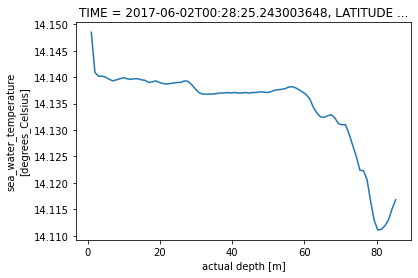

In [95]:
cast[1].TEMP.plot()

In [111]:
xr.concat(cast,dim='TIME')

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'dict'>

In [93]:
xr.concat(cast,dim='TIME')

ValueError: TIME already exists as coordinate or variable name.

In [ ]:
import s3fs
import xarray as xr
form dask import da

s3 = s3fs.S3FileSystem(anon=True)

# This generates a list of strings with filenames
s3path = 's3::imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/*SBE19plus*.nc'
remote_files = s3.glob(s3path)
remote_files
# Iterate through remote_files to create a fileset
fileset = [s3.open(file) for file in remote_files]
xarray_concat_kwargs = dict(coords='minimal',join='override',compat='override',combine_attrs='override',data_vars='minimal',engine='h5netcdf') 
# This works


data = xr.open_mfdataset(fileset, parallel=True,**xarray_concat_kwargs)

In [ ]:
data

In [ ]:
def process_single(url):
    import fsspec
    from kerchunk.hdf import SingleHdf5ToZarr
    
    s3_fn = 's3://' + url
    with fsspec.open(s3_fn, 
                     anon=True, 
                     mode='rb', 
                     default_fill_cache=False, 
                     default_cache_type='none') as f:
        zarr_dict = SingleHdf5ToZarr(f, s3_fn, spec=1, inline_threshold=100).translate()
        
    return zarr_dict  

In [ ]:
def open_single(fn,preprocess=None,storage_options=dict(anon=True)):
    import fsspec
    import xarray as xr
    
    mapper=fsspec.get_mapper('reference://',
                             fo=fn,
                             remote_protocol='s3',
                             remote_options=storage_options,
                            )
    ds = xr.open_zarr(mapper,chunks={}, consolidated=False, decode_times=False)   
    
    if preprocess is not None:
        ds = preprocess(ds)
    
    return ds

In [11]:
ref =process_single(ref_files[0])
a =open_single(ref)
ref =process_single(ref_files[1])
b =open_single(ref)

In [18]:
a.TEMP.values

array([21.9026, 21.9038, 21.9021, 21.8993, 21.9011, 21.9045, 21.9056,
       21.9046, 21.9057, 21.9081, 21.9027, 21.8996, 21.9044, 21.7884,
       21.6258, 21.5738, 21.5151, 21.4703, 21.466 , 21.4603, 21.4427,
       21.4248, 21.4127, 21.3927, 21.3716, 21.3503, 21.3449, 21.3344,
       21.3354, 21.3238, 21.325 , 21.3106, 21.2766], dtype=float32)

In [20]:
import xarray as xr
c =xr.concat([a,b],dim='TIME')

In [21]:
c.TEMP.values

array([[21.9026, 21.9038, 21.9021, 21.8993, 21.9011, 21.9045, 21.9056,
        21.9046, 21.9057, 21.9081, 21.9027, 21.8996, 21.9044, 21.7884,
        21.6258, 21.5738, 21.5151, 21.4703, 21.466 , 21.4603, 21.4427,
        21.4248, 21.4127, 21.3927, 21.3716, 21.3503, 21.3449, 21.3344,
        21.3354, 21.3238, 21.325 , 21.3106, 21.2766,     nan,     nan,
            nan,     nan],
       [21.6923, 21.6948, 21.6958, 21.6943, 21.6928, 21.6941, 21.6935,
        21.6926, 21.6919, 21.6882, 21.6675, 21.65  , 21.6419, 21.6392,
        21.63  , 21.6253, 21.6109, 21.5961, 21.5883, 21.581 , 21.567 ,
        21.5568, 21.5363, 21.5284, 21.5252, 21.5208, 21.5135, 21.4803,
        21.2981, 21.0858, 20.8885, 20.7589, 20.637 , 20.589 , 20.574 ,
        20.5419, 20.5307]], dtype=float32)

In [22]:
import fsspec
from fsspec.core import url_to_fs
fs = fsspec.filesystem('s3',use_listings_cache=False,anon=True,)

ref_files = fs.glob('s3::imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/*SBE19plus*.nc')
ref_files

['imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20200520T012800Z_NRSROT_FV01_Profile-SBE19plus_C-20200525T043352Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20200605T014200Z_NRSROT_FV01_Profile-SBE19plus_C-20200608T023133Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20200710T024000Z_NRSROT_FV01_Profile-SBE19plus_C-20200713T014952Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20200730T021300Z_NRSROT_FV01_Profile-SBE19plus_C-20200731T030516Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20200814T020500Z_NRSROT_FV01_Profile-SBE19plus_C-20200818T054815Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20200825T032500Z_NRSROT_FV01_Profile-SBE19plus_C-20200827T041200Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles/IMOS_ANMN-NRS_CDEFKOSTUZ_20201013T020500Z_NRSROT_FV01

In [ ]:
import fsspec
def loadfile(urlpath):
    print(f's3://{urlpath}')
    with fsspec.open(f's3://{urlpath}',anon=True, mode='rb', default_fill_cache=False, default_cache_type='none') as f:
        x=xr.open_dataset(f,engine='h5netcdf')
    return x
         
casts = [ loadfile(file) for file in ref_files[10:15]]

In [33]:
xr.concat(casts,dim='time')

ValueError: I/O operation on closed file.

In [ ]:
import xarray as xr
import s3fs
fs = s3fs.S3FileSystem(anon=True)
s3path = 'imos-data/IMOS/SRS/OC/gridded/aqua/P1D/2010/05/A.P1D.20100507T000000Z.aust.ipar.nc'

fobj = fs.open(s3path)
ds = xr.open_dataset(fobj,engine='h5netcdf')

In [ ]:
intake_aodn.cat.aodn_s3.NRSROT.read()